&nbsp;

# 2. Base Models
Whenever conducting empirical testing, it is always a good idea to have a point of reference to compare against, this can come in the form of a benchmark. A benchmark is something that serves as a standard by which others may be measured or judged. In the world of machine learning, benchmarks don’t have to consist of world class models, on the contrary a good starting point is always the default algorithms. The point of having a benchmark is to test out our hypotheses to analyze whether our assumptions measure up and perform the way we hypothesize.

In [1]:
# Importing standard libraries. 
import pandas as pd
import numpy as np 
import os
import plotly.express as px
import plotly.graph_objects as go

# Importing functions. 
import visuals

# ML models. 
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Ensemble Models.
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Cross Validation Library.  
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Render on github. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train.csv".format(root)) # Importing the train set.
df.head(2)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,mpg
0,6,173.0,110.0,2725,12.6,81,1,chevrolet citation,23.5
1,8,400.0,170.0,4746,12.0,71,1,ford country squire (sw),13.0


&nbsp;

### Section A: Base Model Testing
In this section we will be exploring a variety of Machine Learning algorithms and how well they perform with our newly processed data. We'll pick out the top 3 best performing models and use them as our benchmarks, when conducting hypotheses. Since this is a regression task, the loss function we will be focusing on is the Mean Squared Error (MSE).  

Furthermore, we'll be constructing a pipeline with applied steps. Since we're dealing with two different data types (numerical and categorical) we will create a ColumnTransformer object that will enable us to apply different transformers to specific feature data types. Because for example, it wouldn't make sense to OneHotEncode a numerical feature. 

**A.1: Splitting Numerical & Categorical Features**<br>
Our first step before constructing our pipeline estimator is to categorize our features into either "numerical" or "categorical".

In [3]:
# Separating our numerical & categorical columns for ColumnTransformer. 
numerical = list(df.select_dtypes(exclude=['object']).columns)
numerical.remove("mpg") # Remove label from data. 
print(f'Numerical columns are: {numerical}')

categorical = list(df.select_dtypes(['object']).columns)
print(f'Categorical columns are: {categorical}')

Numerical columns are: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Categorical columns are: ['car name']


**A.2: Constructing our Pipeline**<br>
As mentioned earlier, specific transforms such as OHE are only suitable for categorical data, so we need to utilize a ColumnTransformer which gives us the ability to apply certain steps to specific data types. We'll then combine and apply this step into our final pipeline just before adding in our model.

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

models, results = list(), list()
modelNames = ['LR', 'EN', 'CART', 'SVR', 'KNN', 'GBR', 'RFR', 'XGB']
modelInstance = [LinearRegression(), ElasticNet(), DecisionTreeRegressor(), SVR(), KNeighborsRegressor(), 
                 RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]

modelScores = {}

# Storing the model name and instance inside as tuples inside a list. 
for name, model in zip(modelNames, modelInstance):
    # Define categorical pipeline.
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

    # Define numerical pipeline
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))])

    # Combine categorical and numerical pipelines.
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical),
        ('num', num_pipe, numerical)])

    # Fit a pipeline with transformers and an estimator to the training data.
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)])

    # Using KFold, with 5 splits. 
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring='neg_mean_squared_error', return_train_score=True)
    results.append(abs(cv_results['test_score']))
    print("%s scored an MSE train score of: %.2f and a test score of: %.2f" % (name, 
                                                                                  abs(cv_results['train_score'].mean()), 
                                                                                  abs(cv_results['test_score'].mean())))
    
    # Storing results to use as benchmark values.
    modelScores[name] = round(abs(cv_results['test_score'].mean()),4)

LR scored an MSE train score of: 0.88 and a test score of: 213575666577669718016.00
EN scored an MSE train score of: 12.33 and a test score of: 12.86
CART scored an MSE train score of: 0.00 and a test score of: 14.69
SVR scored an MSE train score of: 20.71 and a test score of: 21.09
KNN scored an MSE train score of: 11.88 and a test score of: 17.70
GBR scored an MSE train score of: 1.27 and a test score of: 9.06
RFR scored an MSE train score of: 1.81 and a test score of: 8.66
XGB scored an MSE train score of: 0.08 and a test score of: 9.99


**A.3: Table of Results**<br>
Based on the results, the three models I will choose are: Gradient Boosting Regressor, Random Forest Regressor and the XGB Regressor. Even though these models overfitted, they are tree ensemble methods, which means we can implement various techniques to remove overfitting.

| Model | Train MSE | Validation MSE | Overfit | Accept Model |
|---------|---------|---------|---------|---------|
| **Linear Regression** | 0.88 | 21357566... |✔️ |❌ |
| **ElasticNet** | 12.33 | 12.86 |❌ |❌ |
| **Decision Tree** | 0.00 | 13.70 |✔️ |❌ |
| **Support Vector Regressor** | 20.71 | 21.09 |❌ |❌ |
| **K Neighbors Regressor** | 11.88 | 17.70 |✔️ |❌ |
| **Gradient Boosting Regressor** | 1.24 | 9.18 |✔️ |✔️ |
| **Random Forest Regressor** | 1.81 | 8.72 |✔️ |✔️ |
| **XGB Regressor** | 0.08 | 9.99 |✔️ |✔️ |

**A.4: Plotting the 5 Folds Score**<br>
Let's see the distribution of each model's folds.

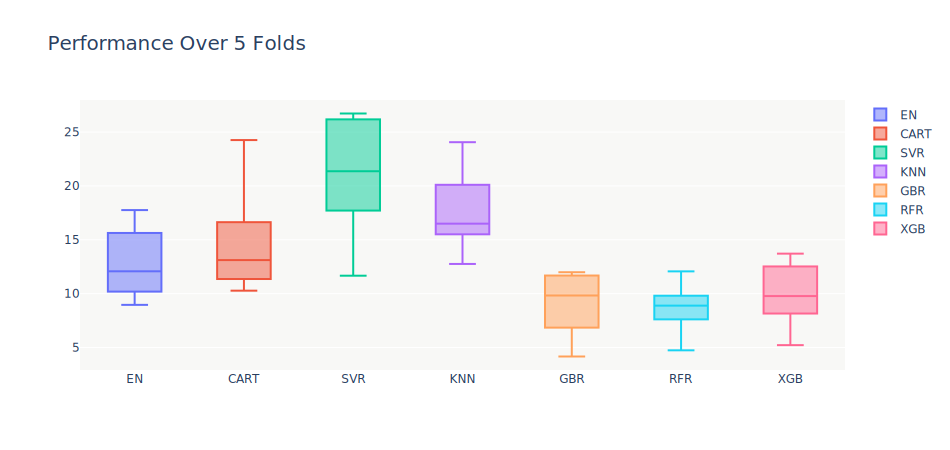

In [5]:
visuals.kfold(scores=results)

* Note that we left out the LinearRegression's result as it's outside the scale of the other regression models.
* Interestingly the models that performed worst off had a higher variance than the models that performed the best.

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  